In [31]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deeplense/dataset/val/no/422.npy
/kaggle/input/deeplense/dataset/val/no/331.npy
/kaggle/input/deeplense/dataset/val/no/2434.npy
/kaggle/input/deeplense/dataset/val/no/280.npy
/kaggle/input/deeplense/dataset/val/no/970.npy
/kaggle/input/deeplense/dataset/val/no/2467.npy
/kaggle/input/deeplense/dataset/val/no/2424.npy
/kaggle/input/deeplense/dataset/val/no/745.npy
/kaggle/input/deeplense/dataset/val/no/100.npy
/kaggle/input/deeplense/dataset/val/no/1200.npy
/kaggle/input/deeplense/dataset/val/no/1170.npy
/kaggle/input/deeplense/dataset/val/no/1876.npy
/kaggle/input/deeplense/dataset/val/no/719.npy
/kaggle/input/deeplense/dataset/val/no/1041.npy
/kaggle/input/deeplense/dataset/val/no/193.npy
/kaggle/input/deeplense/dataset/val/no/1191.npy
/kaggle/input/deeplense/dataset/val/no/461.npy
/kaggle/input/deeplense/dataset/val/no/2196.npy
/kaggle/input/deeplense/dataset/val/no/63.npy
/kaggle/input/deeplense/dataset/val/no/1364.npy
/kaggle/input/deeplense/dataset/val/no/1740.npy
/ka

In [27]:
pip install timm

Note: you may need to restart the kernel to use updated packages.


# DataLOADER to load data from Dateset

In [49]:
import os
import glob
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader

class GalaxyDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        """
        Args:
            file_paths (list of str): Paths to .npy files.
            labels (list of int): 0 or 1 for non-lens / lens.
            transform (callable, optional): A function/transform to apply 
                                            to each image.
        """
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        label = self.labels[idx]

        # Load .npy file
        image = np.load(path)  # shape: (3, 64, 64) or (some shape)
        
        # Example: normalize to [0,1] by min-max
        # (Only do this if not doing more advanced normalization)
        image = (image - image.min()) / (image.max() - image.min() + 1e-8)
        
        # If you have data in shape (3,64,64) that’s already channel-first,
        # you can directly convert it to a tensor.
        image_tensor = torch.tensor(image, dtype=torch.float32)
        
        # If you have a transform pipeline (e.g., with Albumentations or torchvision),
        # apply it here:
        if self.transform is not None:
            # transform expects (H, W, C) for many libraries, so you might need to permute:
            # e.g. image_np = np.transpose(image, (1, 2, 0)) if transform expects channel-last
            # then transform back
            pass
        
        return image_tensor, torch.tensor(label, dtype=torch.long)




In [56]:
from torchvision import transforms

# Training transforms
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(90),  # rotations up to 90 degrees
])


In [57]:
# Load datasets
train_dataset = NPYDataset('/kaggle/input/deeplense/dataset/train', transform=transform)
val_dataset = NPYDataset('/kaggle/input/deeplense/dataset/val', transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


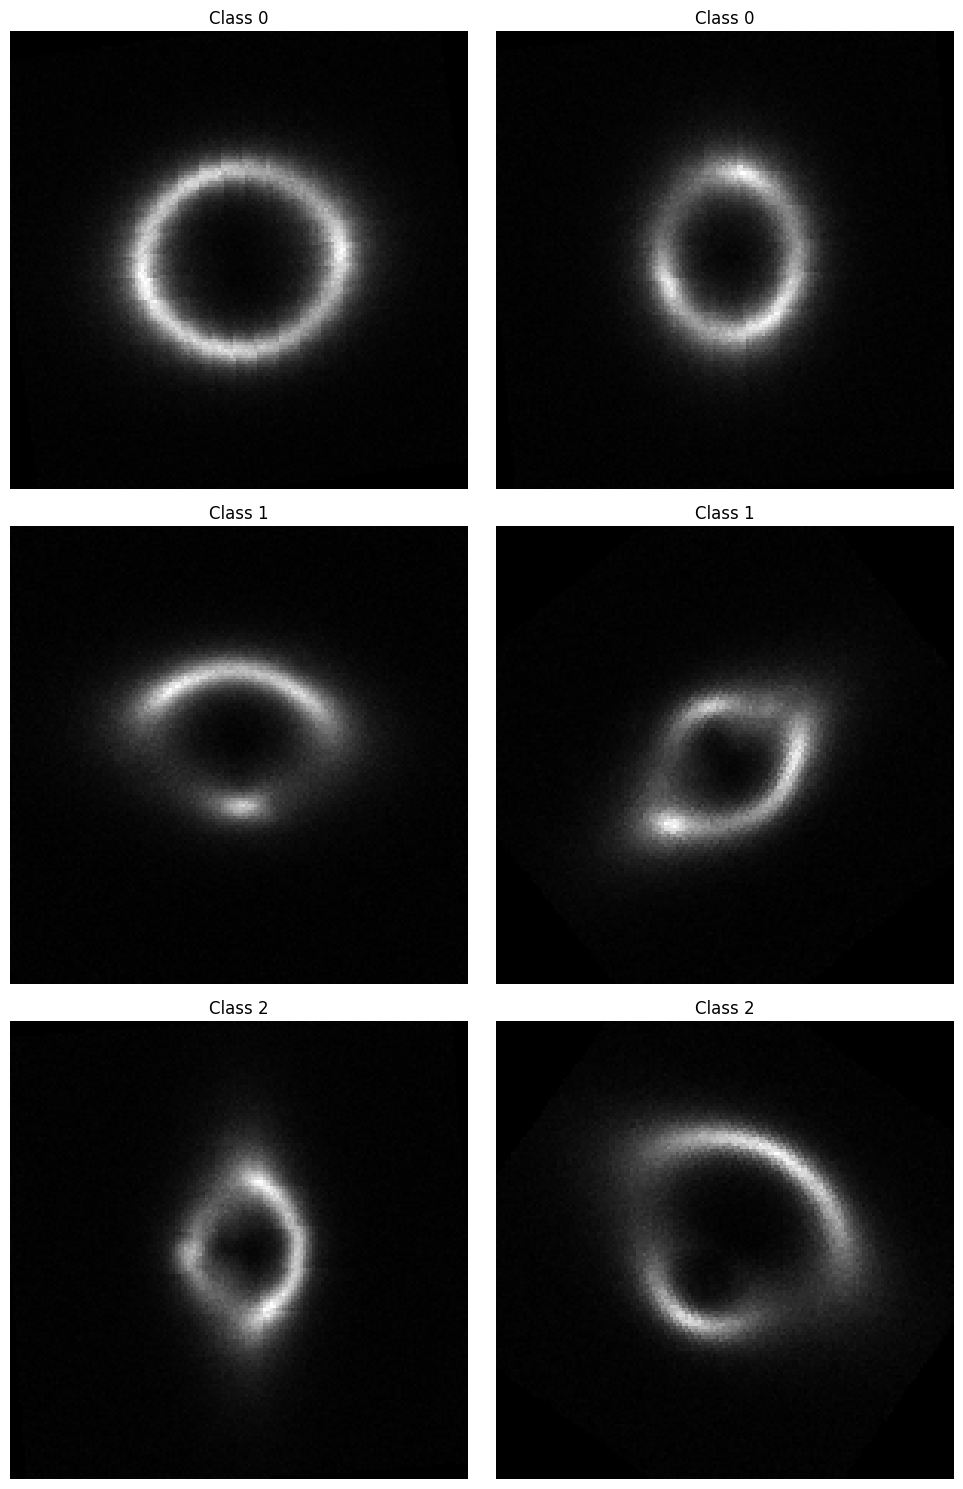

In [58]:
import matplotlib.pyplot as plt

# Create a dictionary to hold the first 2 indices for each class
class_indices = {}
for idx, (_, label) in enumerate(train_dataset.samples):
    if label not in class_indices:
        class_indices[label] = []
    if len(class_indices[label]) < 2:
        class_indices[label].append(idx)

# Collect the indices in order of class (e.g., class 0, then 1, then 2)
selected_indices = []
for label in sorted(class_indices.keys()):
    selected_indices.extend(class_indices[label])

# Create a subplot grid: one row per class (3 rows), 2 columns per row
fig, axes = plt.subplots(len(class_indices), 2, figsize=(10, 15))

for i, idx in enumerate(selected_indices):
    img, label = train_dataset[idx]
    row = i // 2
    col = i % 2
    axes[row, col].imshow(img.squeeze(), cmap='gray')
    axes[row, col].set_title(f"Class {label}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()



# Backbone Timm MODEL for lens Classification

In [59]:
import torch
import torch.nn as nn
import timm

class TimmModelComplex(nn.Module):
    """
    Complex Timm Model for Lens Classification

    This model uses a Timm backbone for feature extraction and a custom multi-layer
    classifier for classifying images into lens categories.
    
    Parameters:
    - name (str): Name of the Timm model (e.g., 'resnet18', 'efficientnet_b0', etc.)
    - in_chans (int): Number of input channels (e.g., 1 for grayscale images)
    - num_classes (int): Number of lens classes to classify
    - pretrained (bool): Whether to load pretrained weights (default: True)
    - tune (bool): If True, the whole backbone is fine-tuned; otherwise, only the classifier is trained
    - dropout_rate (float): Dropout rate used in the classifier (default: 0.5)
    """
    def __init__(self, name, in_chans=1, num_classes=3, pretrained=True, tune=True, dropout_rate=0.5):
        super().__init__()
        # Create the backbone without its classifier (num_classes=0 removes the default classifier)
        self.backbone = timm.create_model(name, pretrained=pretrained, in_chans=in_chans, num_classes=0)
        
        # Freeze backbone parameters if not tuning the whole network
        for param in self.backbone.parameters():
            param.requires_grad = tune
        
        # Determine feature dimension from the backbone
        # Many timm models have a 'num_features' attribute
        feature_dim = self.backbone.num_features
        
        # Define a complex classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feature_dim, 1024),
            nn.PReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.PReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.PReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )
    

    def forward(self, x):
        # Extract features using the backbone
        features = self.backbone.forward_features(x)
        # Apply adaptive average pooling to reduce the spatial dimensions to 1x1
        pooled_features = nn.functional.adaptive_avg_pool2d(features, (1, 1))
        # Flatten the pooled features; shape becomes (batch_size, 512)
        flattened = pooled_features.view(pooled_features.size(0), -1)
        # Pass through the custom classifier
        out = self.classifier(flattened)
        return out


model = TimmModelComplex(name="efficientnet_b0", in_chans=1, num_classes=3, pretrained=True, tune=True, dropout_rate=0.5)


# Model Trainning 

In [66]:
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import roc_auc_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Check if CUDA is available and use it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the complex Timm model for lens classification
# Replace 'resnet18' with your desired timm model architecture if needed.
model = TimmModelComplex(name="efficientnet_b0", in_chans=1, num_classes=3, pretrained=True, tune=True, dropout_rate=0.5)
model.to(device)

# Define loss function and optimizer
best_auc = 0.0

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Training loop
for epoch in range(30):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU

            outputs = model(inputs)
            y_true.extend(labels.cpu().numpy())  # Move to CPU before converting to NumPy
            y_pred.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    auc = roc_auc_score(y_true, y_pred, multi_class='ovr')
    print(f"Epoch {epoch}, Val AUC: {auc:.4f}")

    # Save best model if performance meets threshold
    if auc > 0.9:
        best_auc = auc
        torch.save(model.state_dict(), 'E_model.pth')

    # Early stopping (optional)
    if epoch > 10 and auc < 0.4 and auc > 0.99:
         print("Stopping early due to poor performance.")
         break



Epoch 0, Val AUC: 0.5872
Epoch 1, Val AUC: 0.6779
Epoch 2, Val AUC: 0.7492
Epoch 3, Val AUC: 0.8018
Epoch 4, Val AUC: 0.8460
Epoch 5, Val AUC: 0.8806
Epoch 6, Val AUC: 0.8953
Epoch 7, Val AUC: 0.9203
Epoch 8, Val AUC: 0.9264
Epoch 9, Val AUC: 0.9381
Epoch 10, Val AUC: 0.9390
Epoch 11, Val AUC: 0.9494
Epoch 12, Val AUC: 0.9598
Epoch 13, Val AUC: 0.9623
Epoch 14, Val AUC: 0.9586
Epoch 15, Val AUC: 0.9630
Epoch 16, Val AUC: 0.9683
Epoch 17, Val AUC: 0.9700
Epoch 18, Val AUC: 0.9714
Epoch 19, Val AUC: 0.9722
Epoch 20, Val AUC: 0.9769
Epoch 21, Val AUC: 0.9760
Epoch 22, Val AUC: 0.9743
Epoch 23, Val AUC: 0.9797
Epoch 24, Val AUC: 0.9794
Epoch 25, Val AUC: 0.9815
Epoch 26, Val AUC: 0.9790
Epoch 27, Val AUC: 0.9791
Epoch 28, Val AUC: 0.9820
Epoch 29, Val AUC: 0.9826


# Model Evaluation 

In [67]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score

# Ensure model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Validation phase
y_true = []  # Ground truth labels
y_pred = []  # Predicted probabilities

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        # Move inputs and labels to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)  # Forward pass
        y_true.extend(labels.cpu().numpy())  # Move labels to CPU before converting to NumPy
        y_pred.extend(torch.softmax(outputs, dim=1).cpu().numpy())  # Move predictions to CPU

# Convert y_true to one-hot encoding
num_classes = 3  # Adjust based on your dataset
y_true_onehot = np.eye(num_classes)[y_true]  # Shape: [num_samples, num_classes]

# Compute AUC for each class (One-vs-Rest)
auc_scores = []
for i in range(num_classes):
    auc = roc_auc_score(y_true_onehot[:, i], np.array(y_pred)[:, i])
    auc_scores.append(auc)
    print(f"Class {i} AUC: {auc:.4f}")

# Average AUC
mean_auc = np.mean(auc_scores)
print(f"Mean AUC: {mean_auc:.4f}")


Class 0 AUC: 0.9881
Class 1 AUC: 0.9725
Class 2 AUC: 0.9859
Mean AUC: 0.9822


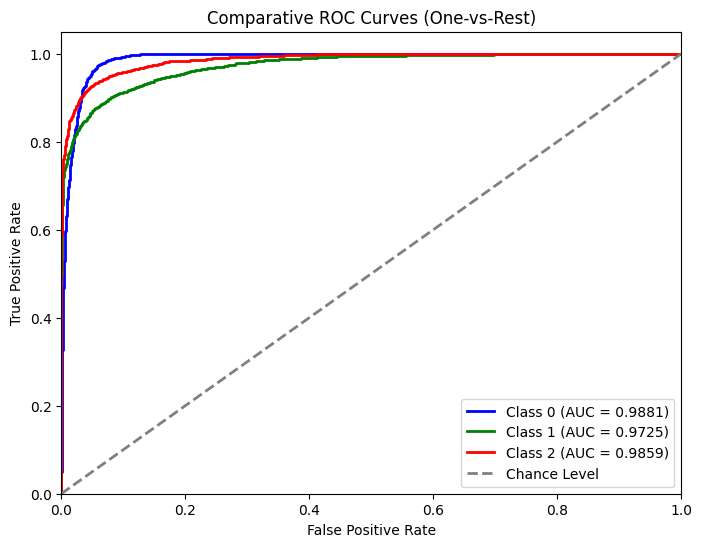

In [68]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Assuming y_true_onehot and y_pred are computed from your validation phase
# y_true_onehot: shape [num_samples, num_classes]
# y_pred: shape [num_samples, num_classes]

num_classes = 3  # Update if needed
colors = ['blue', 'green', 'red']

plt.figure(figsize=(8, 6))
ax = plt.gca()

for i in range(num_classes):
    # Compute False Positive Rate (fpr), True Positive Rate (tpr), and thresholds
    fpr, tpr, _ = roc_curve(y_true_onehot[:, i], np.array(y_pred)[:, i])
    roc_auc = auc(fpr, tpr)
    
    ax.plot(fpr, tpr, color=colors[i], lw=2,
            label=f'Class {i} (AUC = {roc_auc:.4f})')

# Plot the chance line
ax.plot([0, 1], [0, 1], linestyle='--', color='grey', lw=2, label='Chance Level')

# Set plot details
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Comparative ROC Curves (One-vs-Rest)")
ax.legend(loc="lower right")
plt.show()


In [69]:

from torchvision import transforms

# Example transforms for a 1-channel Tensor of shape (1, H, W)
# You can add more transforms if needed (e.g., random flips)
transform = transforms.Compose([
    # If you need to resize or do other augmentations, add them here
    # transforms.Resize((150, 150))  # But your array might already be 150x150
    # If you have a 1-channel Tensor, you can skip ToTensor() because we already have a Tensor
])

# Create dataset for validation
val_dir = "/kaggle/input/deeplense/dataset/val"
val_dataset_full = NPYDataset(root_dir=val_dir, transform=transform)

# 90:10 split into val and test sets
val_size = int(0.9 * len(val_dataset_full))
test_size = len(val_dataset_full) - val_size
val_dataset, test_dataset = torch.utils.data.random_split(val_dataset_full, [val_size, test_size])

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [70]:
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

# Load the best model weights if needed
model.load_state_dict(torch.load('E_model.pth', weights_only=True))

model.to(device)
model.eval()

# Testing phase: Evaluate performance on the test set
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:  # test_loader is your DataLoader for test data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        # Get predicted class (argmax over the logits)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        # Also store probabilities for ROC-AUC
        probabilities = torch.softmax(outputs, dim=1)
        all_probs.extend(probabilities.cpu().numpy())

# Convert lists to NumPy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Calculate Accuracy
accuracy = np.mean(all_preds == all_labels)
print(f"Test Accuracy: {accuracy:.4f}")

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

# Compute multi-class ROC-AUC (One-vs-Rest)
num_classes = 3
all_labels_onehot = np.eye(num_classes)[all_labels]
auc = roc_auc_score(all_labels_onehot, all_probs, multi_class='ovr')
print(f"Test ROC-AUC: {auc:.4f}")


Test Accuracy: 0.9240
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       247
           1       0.87      0.93      0.90       244
           2       0.95      0.92      0.94       259

    accuracy                           0.92       750
   macro avg       0.93      0.92      0.92       750
weighted avg       0.93      0.92      0.92       750

Confusion Matrix:
[[227  16   4]
 [  9 227   8]
 [  3  17 239]]
Test ROC-AUC: 0.9897


Test Accuracy: 0.9240
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       247
           1       0.87      0.93      0.90       244
           2       0.95      0.92      0.94       259

    accuracy                           0.92       750
   macro avg       0.93      0.92      0.92       750
weighted avg       0.93      0.92      0.92       750

Confusion Matrix:
[[227  16   4]
 [  9 227   8]
 [  3  17 239]]
Test ROC-AUC: 0.9897


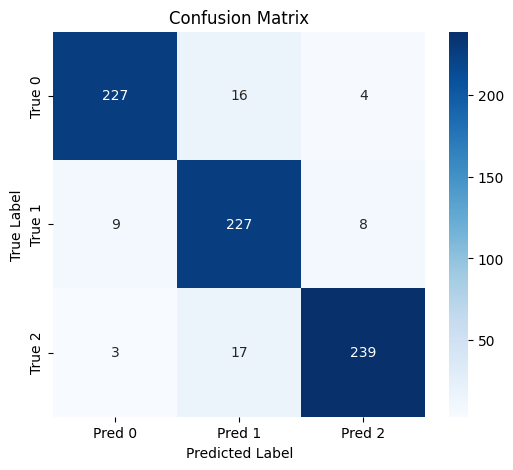

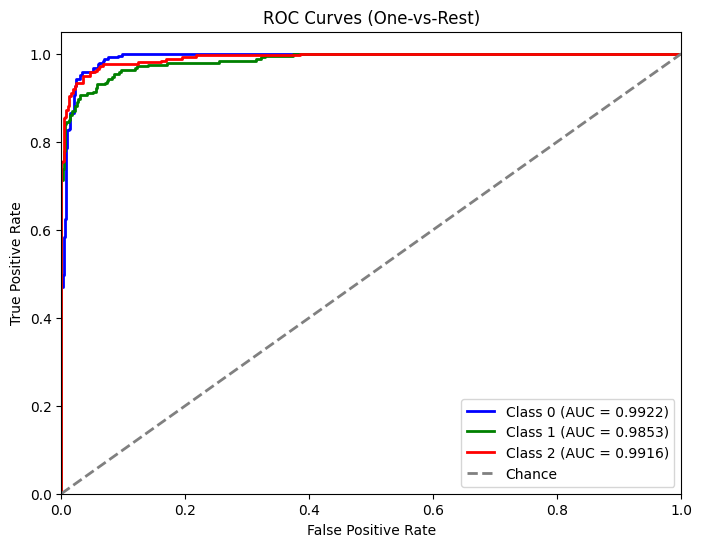

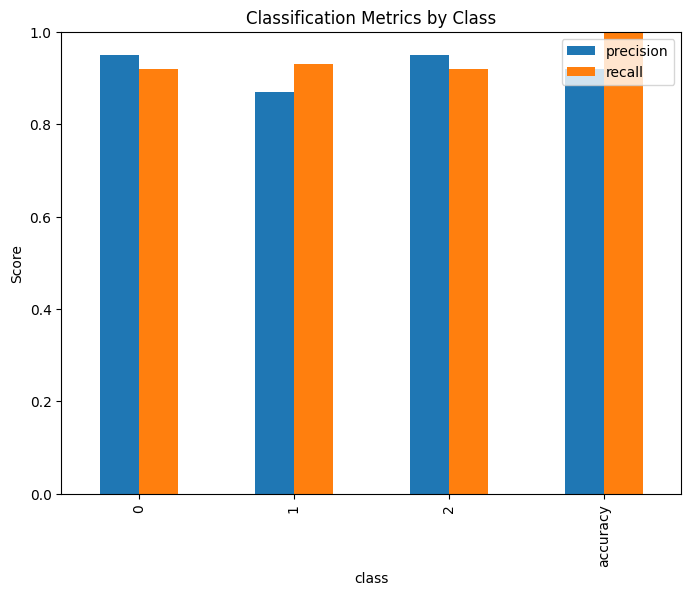

In [71]:
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Load the best model weights if needed
model.load_state_dict(torch.load('E_model.pth', weights_only=True))
model.to(device)
model.eval()

# Testing phase: Evaluate performance on the test set
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:  # test_loader is your DataLoader for test data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        # Get predicted class (argmax over the logits)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        # Also store probabilities for ROC-AUC
        probabilities = torch.softmax(outputs, dim=1)
        all_probs.extend(probabilities.cpu().numpy())

# Convert lists to NumPy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Calculate Accuracy
accuracy = np.mean(all_preds == all_labels)
print(f"Test Accuracy: {accuracy:.4f}")

# Classification Report
report = classification_report(all_labels, all_preds)
print("Classification Report:")
print(report)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

# Compute multi-class ROC-AUC (One-vs-Rest)
num_classes = 3
all_labels_onehot = np.eye(num_classes)[all_labels]
auc_score = roc_auc_score(all_labels_onehot, all_probs, multi_class='ovr')
print(f"Test ROC-AUC: {auc_score:.4f}")

# -----------------------------------
# Visualization Section
# -----------------------------------

# 1. Plot Confusion Matrix as a Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"Pred {i}" for i in range(num_classes)],
            yticklabels=[f"True {i}" for i in range(num_classes)])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 2. Plot ROC Curves for each class
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red']
for i in range(num_classes):
    # Calculate ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(all_labels_onehot[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'Class {i} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='grey', lw=2, label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend(loc="lower right")
plt.show()

# 3. Optionally, plot a bar chart for precision, recall, and f1-score for each class.
# Extracting metrics from the classification report
import pandas as pd
from io import StringIO

# Parse the classification report into a DataFrame
report_data = []
lines = report.split('\n')
for line in lines[2:(len(lines)-3)]:
    row = {}
    tokens = line.split()
    if len(tokens) < 2: continue
    row['class'] = tokens[0]
    row['precision'] = float(tokens[1])
    row['recall'] = float(tokens[2])

    report_data.append(row)
df = pd.DataFrame.from_dict(report_data)

df.set_index('class', inplace=True)
df[['precision','recall']].plot(kind='bar', figsize=(8,6))
plt.title("Classification Metrics by Class")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()


Test Accuracy: 0.9240
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       247
           1       0.87      0.93      0.90       244
           2       0.95      0.92      0.94       259

    accuracy                           0.92       750
   macro avg       0.93      0.92      0.92       750
weighted avg       0.93      0.92      0.92       750

Confusion Matrix:
[[227  16   4]
 [  9 227   8]
 [  3  17 239]]
Test ROC-AUC: 0.9897


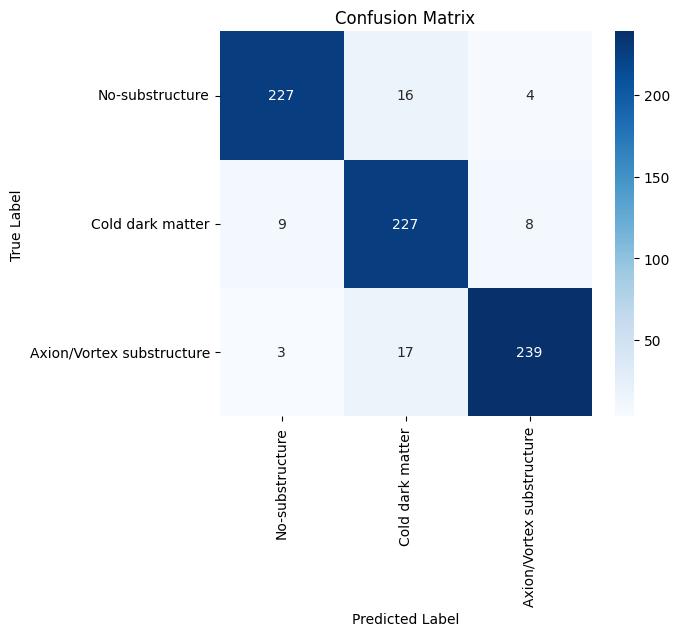

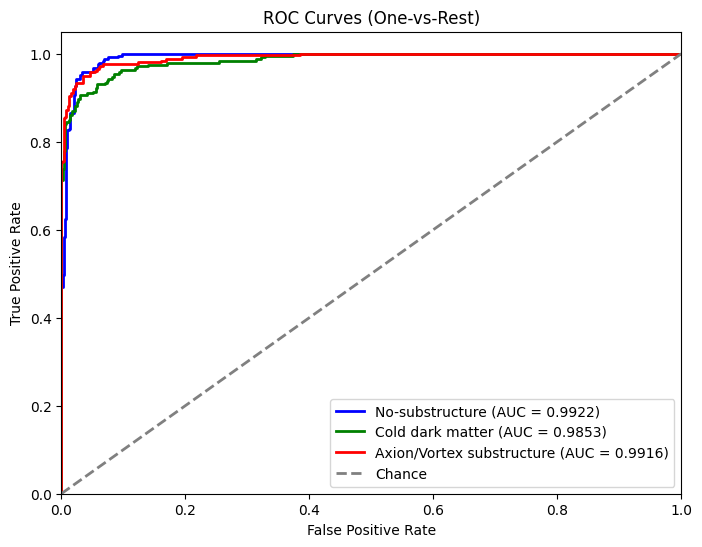

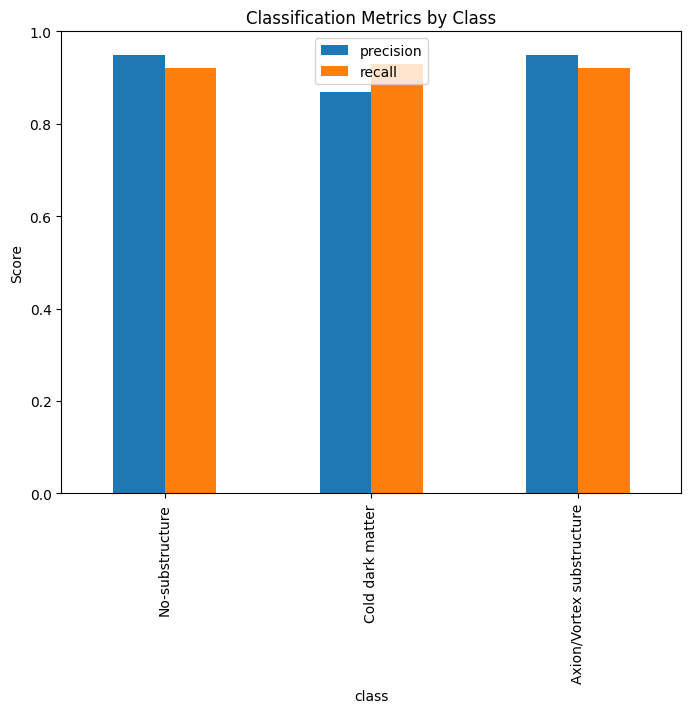

In [72]:
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from io import StringIO

# Define custom class names
class_names = ["No-substructure", "Cold dark matter", "Axion/Vortex substructure"]

# Load the best model weights if needed
model.load_state_dict(torch.load('E_model.pth', weights_only=True))
model.to(device)
model.eval()

# Testing phase: Evaluate performance on the test set
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:  # test_loader is your DataLoader for test data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        # Get predicted class (argmax over the logits)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        # Also store probabilities for ROC-AUC
        probabilities = torch.softmax(outputs, dim=1)
        all_probs.extend(probabilities.cpu().numpy())

# Convert lists to NumPy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Calculate Accuracy
accuracy = np.mean(all_preds == all_labels)
print(f"Test Accuracy: {accuracy:.4f}")

# Classification Report
report = classification_report(all_labels, all_preds)
print("Classification Report:")
print(report)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

# Compute multi-class ROC-AUC (One-vs-Rest)
num_classes = len(class_names)
all_labels_onehot = np.eye(num_classes)[all_labels]
auc_score = roc_auc_score(all_labels_onehot, all_probs, multi_class='ovr')
print(f"Test ROC-AUC: {auc_score:.4f}")

# -----------------------------------
# Visualization Section
# -----------------------------------

# 1. Plot Confusion Matrix as a Heatmap with custom labels
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 2. Plot ROC Curves for each class with custom labels
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red']
for i in range(num_classes):
    # Calculate ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(all_labels_onehot[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='grey', lw=2, label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend(loc="lower right")
plt.show()

# 3. Plot a bar chart for precision and recall for each class with custom labels
# Parse the classification report into a DataFrame, ignoring non-numeric rows
report_data = []
lines = report.split('\n')
for line in lines[2:(len(lines)-3)]:
    tokens = line.split()
    if len(tokens) < 2:
        continue
    if not tokens[0].isdigit():  # Skip lines like "accuracy"
        continue
    row = {}
    class_idx = int(tokens[0])
    row['class'] = class_names[class_idx] if class_idx < len(class_names) else tokens[0]
    row['precision'] = float(tokens[1])
    row['recall'] = float(tokens[2])
    report_data.append(row)

df = pd.DataFrame.from_dict(report_data)
df.set_index('class', inplace=True)
df[['precision','recall']].plot(kind='bar', figsize=(8,6))
plt.title("Classification Metrics by Class")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()


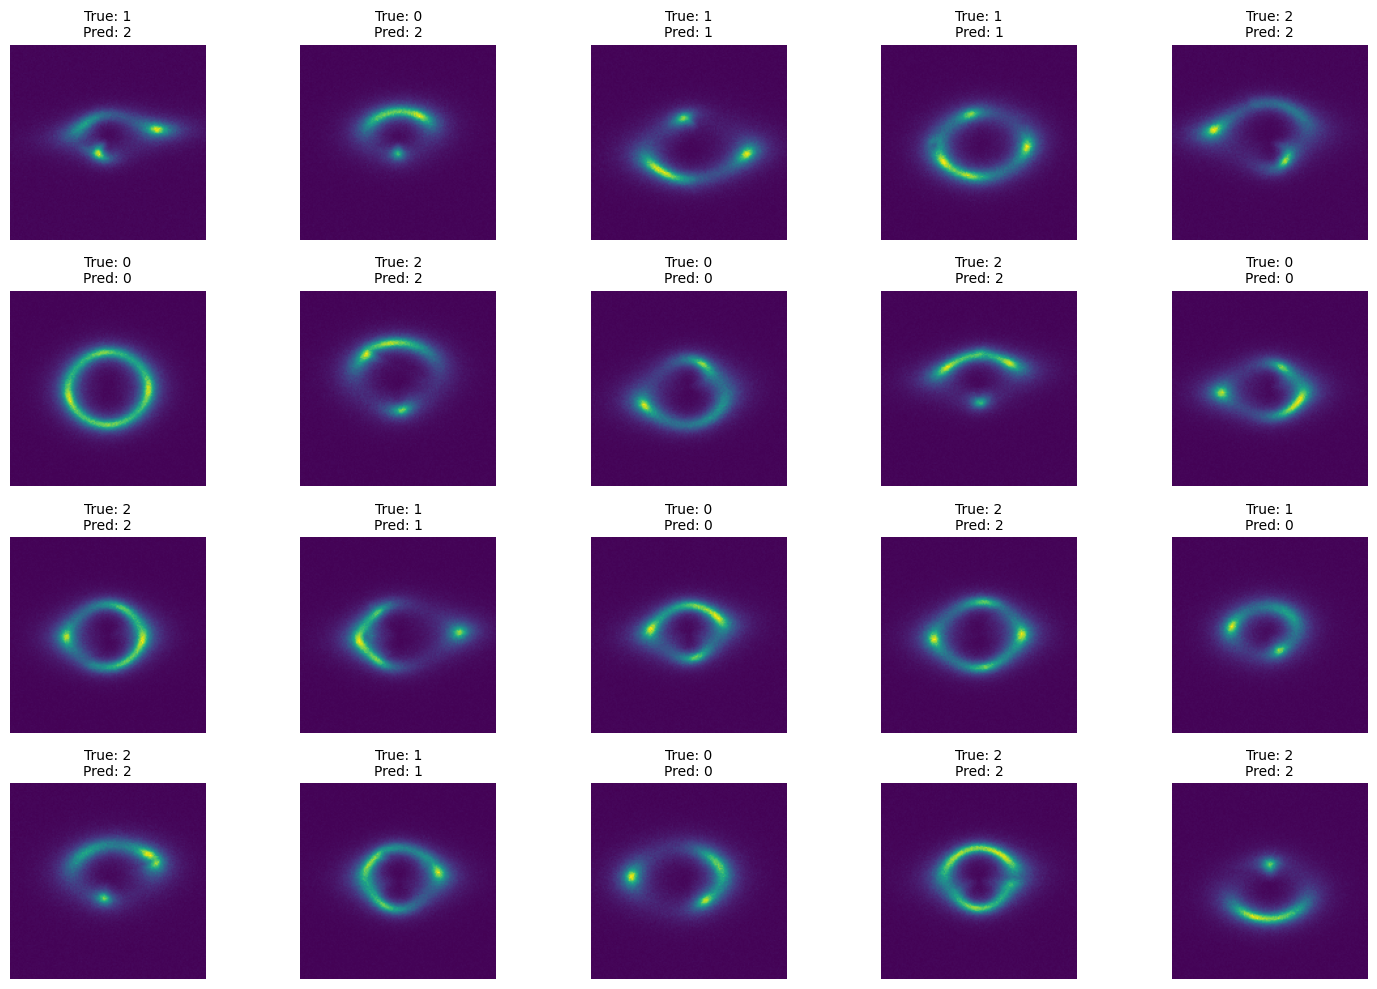

In [73]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

# Retrieve 20 test samples for visualization
sample_images = []
sample_preds = []
sample_true = []

# Iterate over test_loader to get enough samples
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        
        # Append images, predictions, and true labels
        for i in range(len(labels)):
            sample_images.append(inputs[i].cpu())
            sample_preds.append(preds[i].cpu().item())
            sample_true.append(labels[i].cpu().item())
        # Stop after collecting 20 samples
        if len(sample_images) >= 20:
            break

# Function to denormalize images (if needed)
def denormalize(img, mean, std):
    img = img.clone()  # Avoid modifying the original tensor
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)  # Reverse normalization
    return img

# Denormalization parameters (adjust if different)
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

# Plot 20 sample images in a 4x5 grid
num_samples = min(20, len(sample_images))
fig, axes = plt.subplots(4, 5, figsize=(15, 10))
axes = axes.flatten()

for i in range(num_samples):
    # Denormalize and convert tensor to numpy array
    img = denormalize(sample_images[i], mean, std)
    img_np = img.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
    img_np = np.clip(img_np, 0, 1)  # Ensure values are in the correct range
    
    axes[i].imshow(img_np)
    axes[i].set_title(f"True: {sample_true[i]}\nPred: {sample_preds[i]}", fontsize=10)
    axes[i].axis("off")

plt.tight_layout()
plt.show()



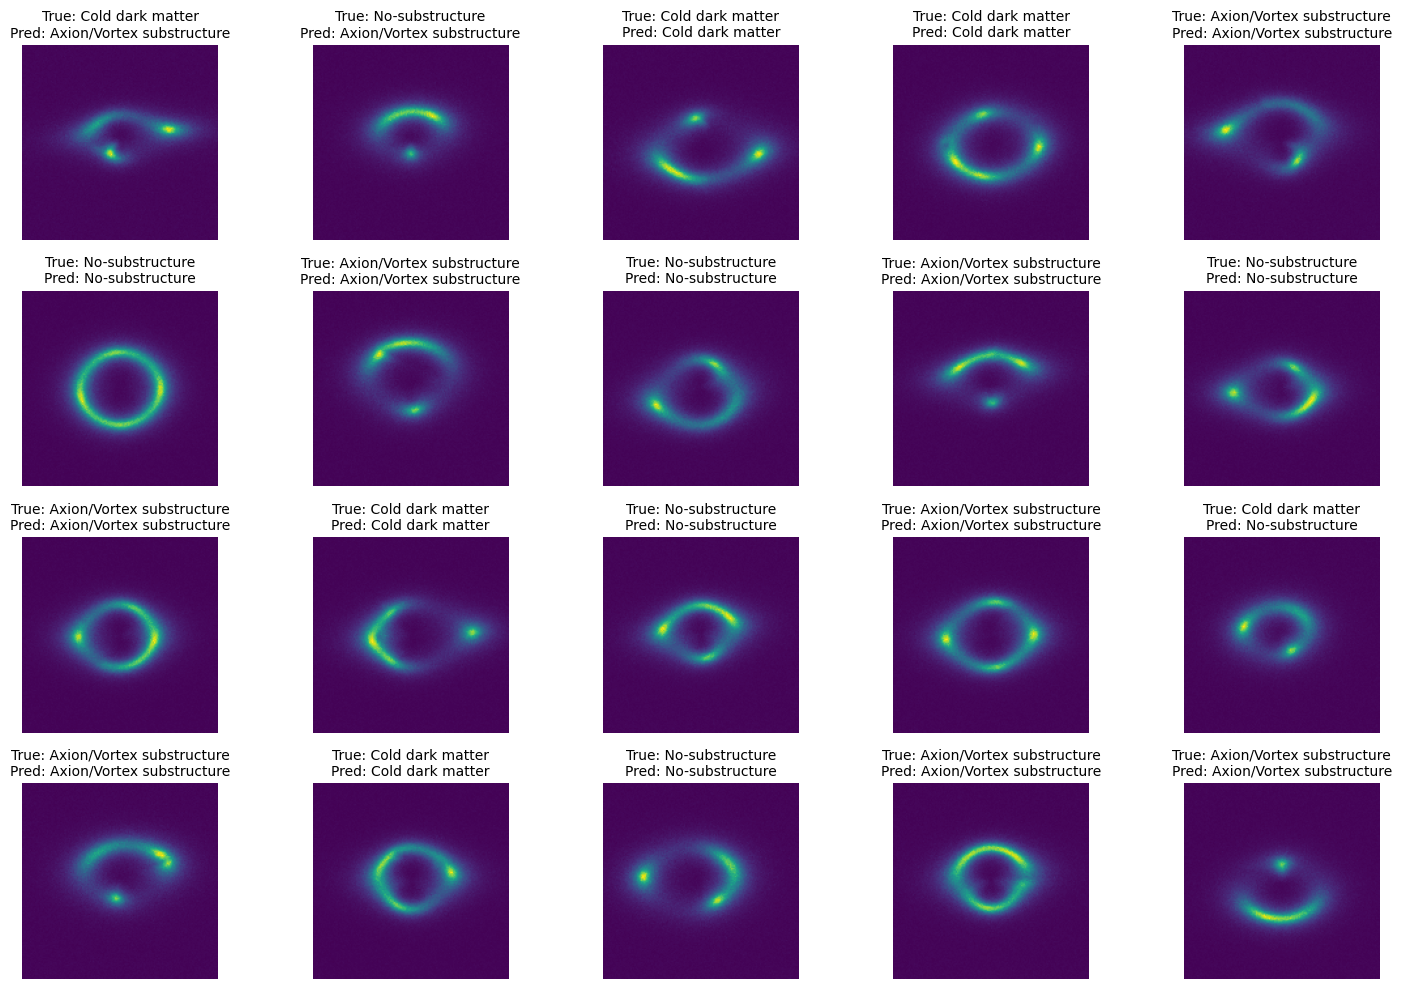

In [74]:
import torch
import numpy as np
import matplotlib.pyplot as plt
model = TimmModelComplex(name="efficientnet_b0", in_chans=1, num_classes=3, pretrained=True, tune=True, dropout_rate=0.5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define custom labels for the classes
class_names = ["No-substructure", "Cold dark matter", "Axion/Vortex substructure"]

# Load your custom model weights and set the model to evaluation mode
# (Make sure 'custom_model.pth' is replaced with your actual model file)
model.load_state_dict(torch.load('E_model.pth', weights_only=True))
model.to(device)
model.eval()

# Retrieve 20 test samples for visualization
sample_images = []
sample_preds = []
sample_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        # Append images, predictions, and true labels from the batch
        for i in range(len(labels)):
            sample_images.append(inputs[i].cpu())
            sample_preds.append(preds[i].cpu().item())
            sample_true.append(labels[i].cpu().item())
        if len(sample_images) >= 20:
            break

# Function to denormalize images (if needed)
def denormalize(img, mean, std):
    img = img.clone()  # Avoid modifying the original tensor
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)  # Reverse the normalization
    return img

# Denormalization parameters (adjust if different)
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

# Plot 20 sample images in a 4x5 grid
num_samples = min(20, len(sample_images))
fig, axes = plt.subplots(4, 5, figsize=(15, 10))
axes = axes.flatten()

for i in range(num_samples):
    # Denormalize and convert tensor to a NumPy array
    img = denormalize(sample_images[i], mean, std)
    img_np = img.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
    img_np = np.clip(img_np, 0, 1)  # Ensure values are in the correct range
    
    # Map numeric labels to custom labels
    true_label = class_names[sample_true[i]]
    pred_label = class_names[sample_preds[i]]
    
    axes[i].imshow(img_np)
    axes[i].set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
    axes[i].axis("off")

plt.tight_layout()
plt.show()
